In [1]:
!pip install albumentations

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import useful tools
from glob import glob
from PIL import Image
import cv2

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

# import data augmentation
import albumentations as albu

In [3]:
import boto3
from sagemaker import get_execution_role
import s3fs

In [4]:
role = get_execution_role()
bucket='fgc-dataset-sagemaker'

TRAIN_DIR = "global-wheat-detection-2020/train/"
TEST_DIR = "global-wheat-detection-2020/test/"
TRAIN_CSV_PATH = "global-wheat-detection-2020/train.csv"

fs = s3fs.S3FileSystem()
train_fns = fs.glob('s3://{}/{}'.format(bucket, TRAIN_DIR) + '*')
test_fns = fs.glob('s3://{}/{}'.format(bucket, TEST_DIR) + '*')

In [5]:
print('Number of train images is {}'.format(len(train_fns)))
print('Number of test images is {}'.format(len(test_fns)))

Number of train images is 3422
Number of test images is 10


In [6]:
# Load the dataframe with the bounding boxes
train = pd.read_csv('s3://{}/{}'.format(bucket, TRAIN_CSV_PATH))

# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [7]:
print('{} images without wheat heads.'.format(len(all_train_images) - len(train)))

49 images without wheat heads.


In [8]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
        
    return bboxes

In [9]:
def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = fs.open('s3://{}/{}{}'.format(bucket, TRAIN_DIR, img_id) + '.jpg', 'rb')
            img = Image.open(img)
            # img = img.read()
            # raw = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_UNCHANGED)
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

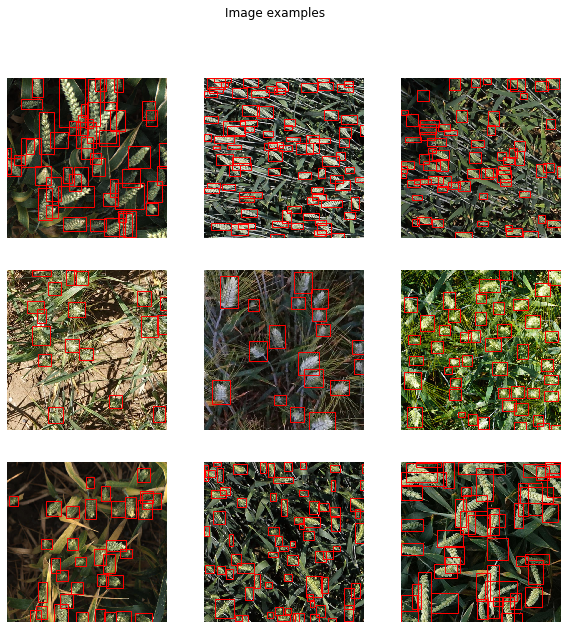

In [10]:
plot_image_examples(all_train_images)

In [11]:
# compute the number of bounding boxes per train image
all_train_images['count'] = all_train_images.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
train_images_count = all_train_images.groupby('image_id').sum().reset_index()

In [12]:
# See this article on how to plot bar charts with Bokeh:
# https://towardsdatascience.com/interactive-histograms-with-bokeh-202b522265f3
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 600,
          title = title,
          x_axis_label = column,
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [13]:
hist_hover(train_images_count, 'count', title='Number of wheat spikes per image')

Loading BokehJS ...

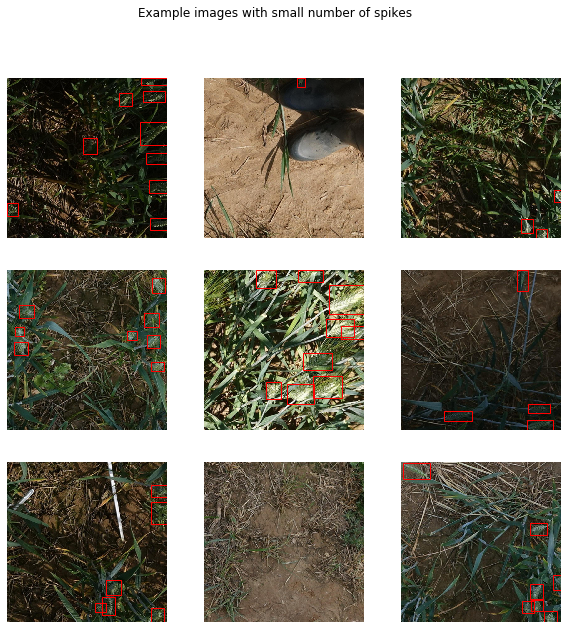

In [14]:
less_spikes_ids = train_images_count[train_images_count['count'] < 10].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(less_spikes_ids)], title='Example images with small number of spikes')

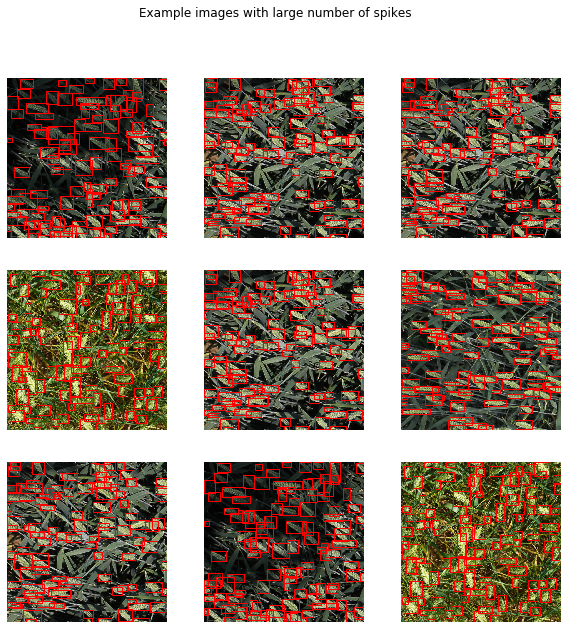

In [15]:
many_spikes_ids = train_images_count[train_images_count['count'] > 100].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(many_spikes_ids)], title='Example images with large number of spikes')

In [16]:
# compute bounding box areas
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']


In [17]:
# plot a histogram of bounding box areas
hist_hover(all_train_images, 'bbox_area', title='Area of a single bounding box')

Loading BokehJS ...

In [18]:
all_train_images.bbox_area.max()

529788.0

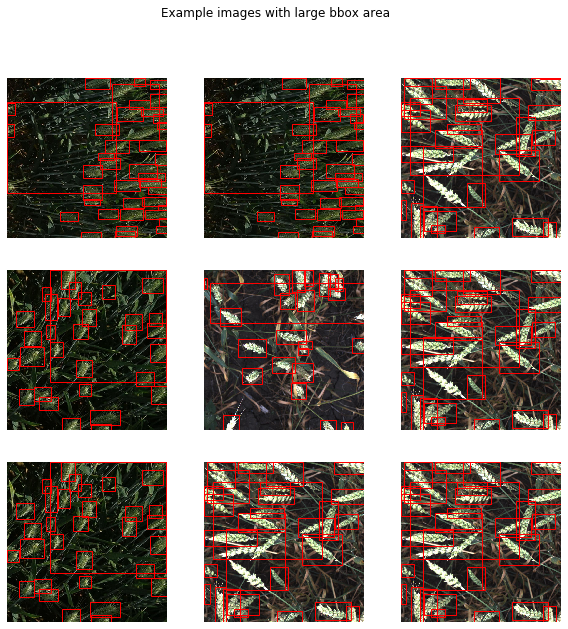

In [19]:
large_boxes_ids = all_train_images[all_train_images['bbox_area'] > 200000].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(large_boxes_ids)], title='Example images with large bbox area')

In [20]:
min_area = all_train_images[all_train_images['bbox_area'] > 0].bbox_area.min()
print('The smallest bounding box area is {}'.format(min_area))

The smallest bounding box area is 2.0


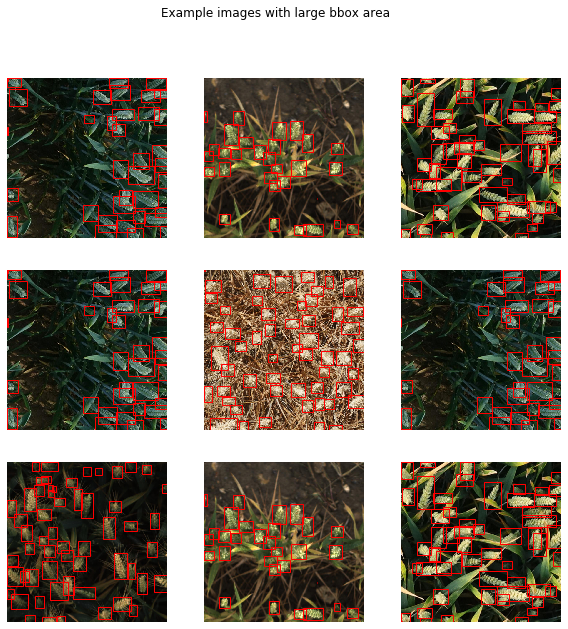

In [21]:
small_boxes_ids = all_train_images[(all_train_images['bbox_area'] < 50) & (all_train_images['bbox_area'] > 0)].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(small_boxes_ids)], title='Example images with large bbox area')

In [22]:
# compute the total bounding boxes area per image
area_per_image = all_train_images.groupby(by='image_id').sum().reset_index()

# compute the percentage of the image area covered by bounding boxes
area_per_image_percentage = area_per_image.copy()
area_per_image_percentage['bbox_area'] = area_per_image_percentage['bbox_area'] / (1024*1024) * 100


In [23]:
hist_hover(area_per_image_percentage, 'bbox_area', title='Percentage of image area covered by bounding boxes')

Loading BokehJS ...

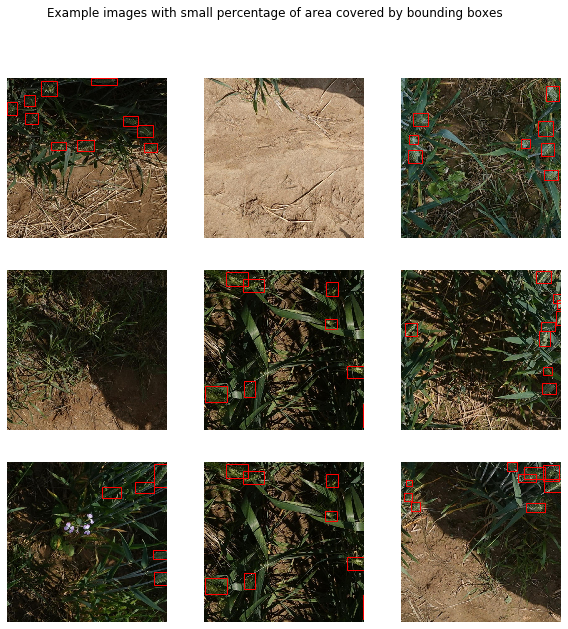

In [24]:
small_area_perc_ids = area_per_image_percentage[area_per_image_percentage['bbox_area'] < 7].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(small_area_perc_ids)], title='Example images with small percentage of area covered by bounding boxes')

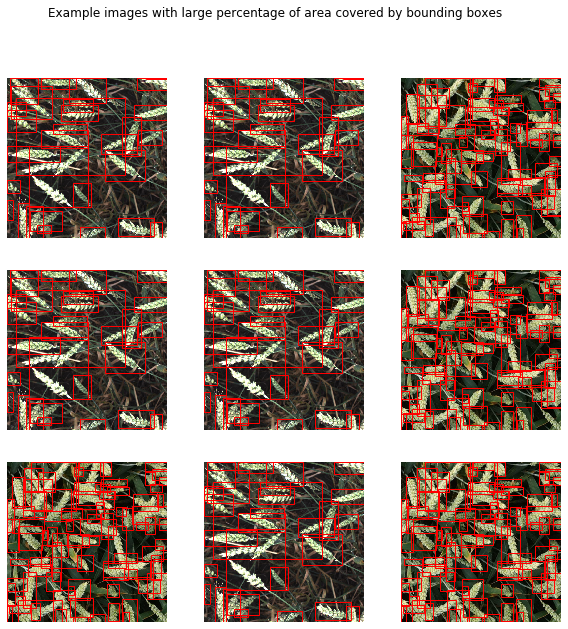

In [25]:
large_area_perc_ids = area_per_image_percentage[area_per_image_percentage['bbox_area'] > 95].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(large_area_perc_ids)], title='Example images with large percentage of area covered by bounding boxes')

In [26]:
def get_image_brightness(image):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # get average brightness
    return np.array(gray).mean()

In [27]:
def add_brightness(df):
    brightness = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        
        img = fs.open('s3://{}/{}{}'.format(bucket, TRAIN_DIR, img_id) + '.jpg', 'rb')
        # img = Image.open(img)
        img = img.read()
        raw = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
        image = np.float32(raw)
        # image = cv2.cvtColor(np.float32(raw), cv2.COLOR_BGR2RGB)
        # image = cv2.imread(img)
        brightness.append(get_image_brightness(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['brightness']
    df = pd.concat([df, brightness_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'brightness']
    
    return df

In [28]:
images_df = pd.DataFrame(all_train_images.image_id.unique())
images_df.columns = ['image_id']

In [29]:
# add brightness to the dataframe
# This takes time 
images_df = pd.DataFrame(all_train_images.image_id.unique())
images_df.columns = ['image_id']
brightness_df = add_brightness(images_df)

all_train_images = all_train_images.merge(brightness_df, on='image_id')


KeyboardInterrupt: 

In [ ]:
hist_hover(all_train_images, 'brightness', title='Images brightness distribution')


In [ ]:
dark_ids = all_train_images[all_train_images['brightness'] < 30].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(dark_ids)], title='Darkest images')

In [ ]:
bright_ids = all_train_images[all_train_images['brightness'] > 130].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(bright_ids)], title='Brightest images')

In [30]:
def get_percentage_of_green_pixels(image):
    # convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # get the green mask
    hsv_lower = (40, 40, 40) 
    hsv_higher = (70, 255, 255)
    green_mask = cv2.inRange(hsv, hsv_lower, hsv_higher)
    
    return float(np.sum(green_mask)) / 255 / (1024 * 1024)

def get_percentage_of_yellow_pixels(image):
    # convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # get the green mask
    hsv_lower = (25, 40, 40) 
    hsv_higher = (35, 255, 255)
    yellow_mask = cv2.inRange(hsv, hsv_lower, hsv_higher)
    
    return float(np.sum(yellow_mask)) / 255 / (1024 * 1024)

def add_green_pixels_percentage(df):
    green = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        img = fs.open('s3://{}/{}{}'.format(bucket, TRAIN_DIR, img_id) + '.jpg', 'rb')
        # img = Image.open(img)
        img = img.read()
        raw = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
        image = np.float32(raw)
        
        green.append(get_percentage_of_green_pixels(image))
        
    green_df = pd.DataFrame(green)
    green_df.columns = ['green_pixels']
    df = pd.concat([df, green_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'green_pixels']
    
    return df

def add_yellow_pixels_percentage(df):
    yellow = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        img = fs.open('s3://{}/{}{}'.format(bucket, TRAIN_DIR, img_id) + '.jpg', 'rb')
        # img = Image.open(img)
        img = img.read()
        raw = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
        image = np.float32(raw)
        
        yellow.append(get_percentage_of_yellow_pixels(image))
        
    yellow_df = pd.DataFrame(yellow)
    yellow_df.columns = ['yellow_pixels']
    df = pd.concat([df, yellow_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'yellow_pixels']
    
    return df

In [31]:
# add a column with the percentage of green pixels
green_pixels_df = add_green_pixels_percentage(images_df)
all_train_images = all_train_images.merge(green_pixels_df, on='image_id')

KeyboardInterrupt: 

In [ ]:
hist_hover(all_train_images, 'green_pixels', title='Percentage of green pixels distribution', colors=['#c3ea84', '#3e7a17'])


In [ ]:
green_ids = all_train_images[all_train_images['green_pixels'] > 0.55].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(green_ids)], title='The most green images')

In [ ]:
# add a column with the percentage of yellow pixels
yellow_pixels_df = add_yellow_pixels_percentage(images_df)
all_train_images = all_train_images.merge(yellow_pixels_df, on='image_id')

In [ ]:
hist_hover(all_train_images, 'yellow_pixels', title='Percentage of yellow pixels distribution', colors=['#fffedb', '#fffeab'])

In [ ]:
yellow_ids = all_train_images[all_train_images['yellow_pixels'] > 0.55].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(yellow_ids)], title='The most yellow images')

In [32]:
# setup an example augmentation pipeline
# be sure to use bbox safe functions for data augmentation
example_transforms = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness()], p=1.0),
    albu.CLAHE(p=1.0)], p=1.0, bbox_params=albu.BboxParams(format='coco', label_fields=['category_id']))

In [39]:
def apply_transforms(transforms, df, n_transforms=3):
    idx = np.random.randint(len(df), size=1)[0]
    
    image_id = df.iloc[idx].image_id
    bboxes = []
    for _, row in df[df.image_id == image_id].iterrows():
        bboxes.append([row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height])
        
    img = fs.open('s3://{}/{}{}'.format(bucket, TRAIN_DIR, image_id) + '.jpg', 'rb')
    image = Image.open(img)          
    # image = Image.open(TRAIN_DIR + image_id + '.jpg')
    
    fig, axs = plt.subplots(1, n_transforms+1, figsize=(15,7))
    
    # plot the original image
    axs[0].imshow(image)
    axs[0].set_title('original')
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
    
    # apply transforms n_transforms times
    for i in range(n_transforms):
        params = {'image': np.asarray(image),
                  'bboxes': bboxes,
                  'category_id': [1 for j in range(len(bboxes))]}
        augmented_boxes = transforms(**params)
        bboxes_aug = augmented_boxes['bboxes']
        image_aug = augmented_boxes['image']

        # plot the augmented image and augmented bounding boxes
        axs[i+1].imshow(image_aug)
        axs[i+1].set_title('augmented_' + str(i+1))
        for bbox in bboxes_aug:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[i+1].add_patch(rect)
    plt.show()

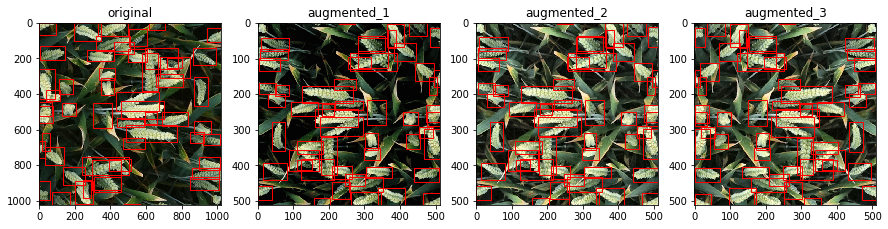

In [40]:
apply_transforms(example_transforms, all_train_images, n_transforms=3)

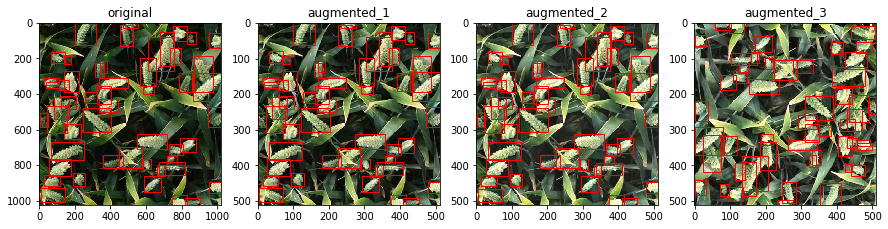

In [41]:
apply_transforms(example_transforms, all_train_images, n_transforms=3)

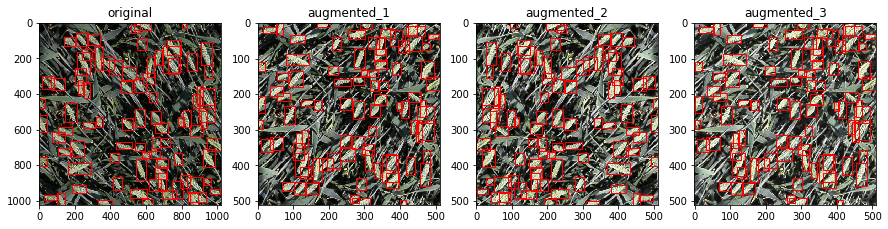

In [42]:
apply_transforms(example_transforms, all_train_images, n_transforms=3)